In [1]:
# Libraries

import pandas as pd
import numpy as np

# Loading processed dataset
df = pd.read_pickle("../processed/feature_engineered_df.pkl")
print(f"✔ Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
df.head()

✔ Data loaded: 1,754,155 rows, 15 columns


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_HOUR,TX_WEEKDAY,TX_MONTH,IS_WEEKEND,TX_AMOUNT_BIN,TX_COUNT
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,0,6,4,1,50-100,686
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,0,6,4,1,50-100,738
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,0,6,4,1,100-500,338
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,0,6,4,1,50-100,599
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,0,6,4,1,50-100,494


In [3]:
# Selection of important columns for prediction
id_columns = ["TRANSACTION_ID", "CUSTOMER_ID", "TX_DATETIME", "TERMINAL_ID"]
df_ids = df[id_columns].copy()

# Target
target_col = "TX_FRAUD"
y = df[target_col]

# Dropping non-feature columns
drop_cols = id_columns + [target_col]
X = df.drop(columns=drop_cols)

print(f"Feature set shape: {X.shape}")
print(f"Target distibution:\n{y.value_counts(normalize=True) * 100}")
X.head()

Feature set shape: (1754155, 10)
Target distibution:
TX_FRAUD
0    99.163073
1     0.836927
Name: proportion, dtype: float64


,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD_SCENARIO,TX_HOUR,TX_WEEKDAY,TX_MONTH,IS_WEEKEND,TX_AMOUNT_BIN,TX_COUNT
0,57.16,31,0,0,0,6,4,1,50-100,686
1,81.51,130,0,0,0,6,4,1,50-100,738
2,146.00,476,0,0,0,6,4,1,100-500,338
3,64.49,569,0,0,0,6,4,1,50-100,599
4,50.99,634,0,0,0,6,4,1,50-100,494


In [4]:
# Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Categorical and Numerical
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_AMOUNT_BIN']
Numerical columns: ['TX_AMOUNT', 'TX_FRAUD_SCENARIO', 'TX_HOUR', 'TX_WEEKDAY', 'TX_MONTH', 'IS_WEEKEND', 'TX_COUNT']


In [5]:
# OneHotEncoding and Passthrough
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)
print("✅ The Encoding has been successful")

✅ The Encoding has been successful


In [8]:
# Train and Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (1403324, 10), Test set: (350831, 10)


In [27]:
# Comparing Algorithms to check which one should be used for training
# Libraries
import time
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Making copies for no overwrite original datasets
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

# Drop leakage column
X_train_enc = X_train_enc.drop(columns=["TX_FRAUD_SCENARIO"])
X_test_enc = X_test_enc.drop(columns=["TX_FRAUD_SCENARIO"])

categorical_cols = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_AMOUNT_BIN']

for col in categorical_cols:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_enc[col])
    
    # Create mapping dict
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # Map test values; unseen labels -> -1
    X_test_enc[col] = X_test_enc[col].map(mapping).fillna(-1).astype(int)

# Sample for faster comparison
sample_frac = 0.12  # ~200k rows
X_sample = X_train_enc.sample(frac=sample_frac, random_state=42)
y_sample = y_train.loc[X_sample.index]

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LogisticRegression": LogisticRegression(max_iter=500, solver='liblinear'),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1, verbosity=0)
}

results = []

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    start_time = time.time()
    model.fit(X_sample, y_sample)
    elapsed = time.time() - start_time
    
    y_pred = model.predict(X_test_enc)
    y_proba = model.predict_proba(X_test_enc)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    results.append((name, auc, elapsed))
    print(f"✅ {name} - AUC: {auc:.4f} | Time: {elapsed:.2f} sec")
    print(classification_report(y_test, y_pred, digits=4))

# Summary table
results_df = pd.DataFrame(results, columns=["Model", "AUC", "Train_Time_Seconds"])
display(results_df.sort_values(by="AUC", ascending=False))


🔹 Training RandomForest...
✅ RandomForest - AUC: 0.6493 | Time: 14.10 sec
              precision    recall  f1-score   support

           0     0.9935    1.0000    0.9967    347895
           1     1.0000    0.2241    0.3662      2936

    accuracy                         0.9935    350831
   macro avg     0.9967    0.6121    0.6815    350831
weighted avg     0.9935    0.9935    0.9915    350831


🔹 Training LogisticRegression...
✅ LogisticRegression - AUC: 0.5769 | Time: 0.70 sec
              precision    recall  f1-score   support

           0     0.9921    0.9947    0.9934    347895
           1     0.0902    0.0623    0.0737      2936

    accuracy                         0.9869    350831
   macro avg     0.5411    0.5285    0.5336    350831
weighted avg     0.9846    0.9869    0.9857    350831


🔹 Training LightGBM...
[LightGBM] [Info] Number of positive: 1413, number of negative: 166986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.01

,Model,AUC,Train_Time_Seconds
0,RandomForest,0.649298,14.096474
2,LightGBM,0.629603,0.712284
3,XGBoost,0.620038,0.588508
1,LogisticRegression,0.576877,0.700774


In [30]:
# Drop leakage column before encoding
X_train_enc = X_train.drop(columns=["TX_FRAUD_SCENARIO"]).copy()
X_test_enc = X_test.drop(columns=["TX_FRAUD_SCENARIO"]).copy()

# Encode categorical columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_enc[col])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_test_enc[col] = X_test_enc[col].map(mapping).fillna(-1).astype(int)
    encoders[col] = le

# Train RandomForest
from sklearn.ensemble import RandomForestClassifier
final_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_enc, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [31]:
import joblib
joblib.dump({
    "model": final_model,
    "encoders": encoders,
    "categorical_cols": categorical_cols
}, "../models/fraud_detection_model.pkl")

print("✅ Final XGBoost model and encoders saved to fraud_detection_model.pkl")

✅ Final XGBoost model and encoders saved to fraud_detection_model.pkl


In [32]:
# Predictions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

y_pred = final_model.predict(X_test_enc)
y_proba = final_model.predict_proba(X_test_enc)[:, 1]

# Sample table for report
sample_results = X_test.copy()
sample_results["Actual"] = y_test
sample_results["Predicted"] = y_pred
sample_results["Fraud_Probability"] = y_proba
display(sample_results.head(10))

,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD_SCENARIO,TX_HOUR,TX_WEEKDAY,TX_MONTH,IS_WEEKEND,TX_AMOUNT_BIN,TX_COUNT,Actual,Predicted,Fraud_Probability
428794,123.17,3853960,44,0,14,1,5,0,100-500,649,0,0,0.023333
1447029,77.80,13039094,150,0,21,2,8,0,50-100,401,0,0,0.010000
397859,23.44,3582932,41,0,11,5,5,1,10-50,669,0,0,0.000000
1464421,11.95,13192232,152,0,16,4,8,0,10-50,696,0,0,0.043333
634047,67.41,5721987,66,0,5,2,6,0,50-100,428,0,0,0.020000
1362660,100.69,12292205,142,0,6,1,8,0,100-500,302,0,0,0.016667
662234,4.69,5974567,69,0,3,5,6,1,0-10,471,0,0,0.006667
162793,16.79,1465123,16,0,22,1,4,0,10-50,679,0,0,0.016667
1208836,25.98,10903554,126,0,4,6,8,1,10-50,440,0,0,0.020000
224450,78.52,2024489,23,0,10,1,4,0,50-100,324,0,0,0.020000


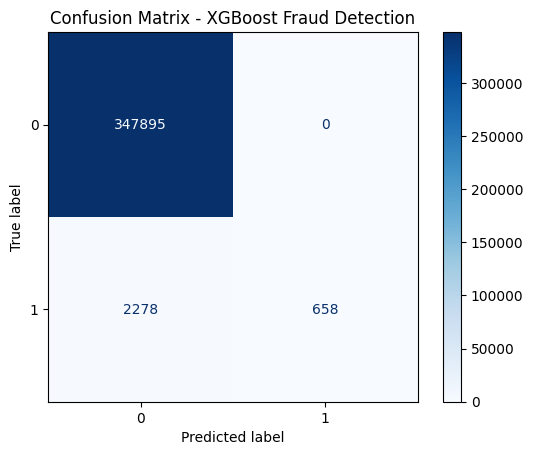

In [33]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost Fraud Detection")
plt.show()

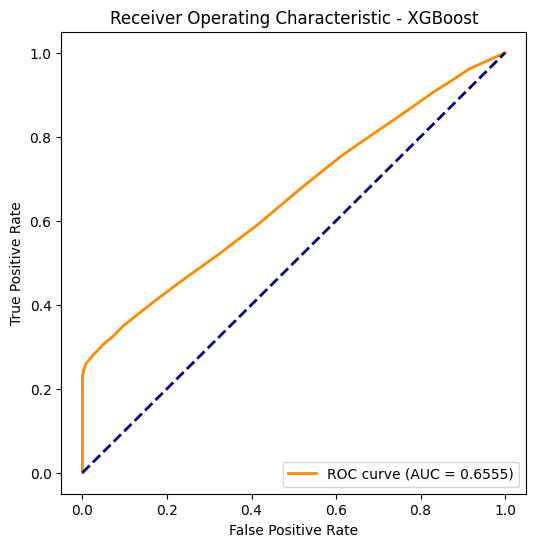

In [34]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - XGBoost")
plt.legend(loc="lower right")
plt.show()

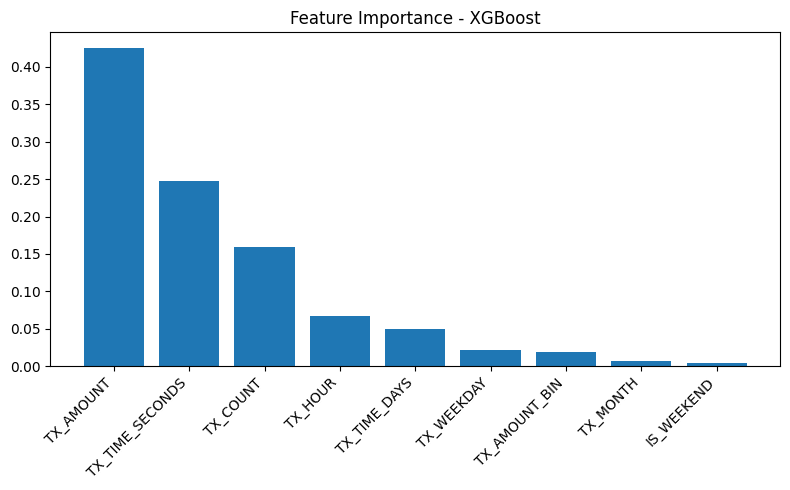

In [35]:
# Features Importance
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,5))
plt.bar(range(X_train_enc.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_enc.shape[1]), X_train_enc.columns[indices], rotation=45, ha="right")
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

In [36]:
joblib.dump(encoders, "../models/encoders.pkl")
print("✅ Encoders saved separately to encoders.pkl")

✅ Encoders saved separately to encoders.pkl
